In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

In [2]:
data = pd.read_pickle(r"../data/B00020S.pkl")
data['Date'] = pd.to_datetime(data['Date'])

## Tworzenie zbioru treningowego i testowego

Wartości przesunięcia w czasie względem stacji w Głogowie zostały wybrane na podstawie ręcznej analizy różnicy czasu pomiędzy peakami poziomu wody w poszczególnych stacjach oraz na podstawie współczynników korelacji Pearsona (pod uwagę brany był najwyższy współczynnik oraz te bardzo bliskie najwyższego). Głównym celem była minimalizacja AIC, pod uwagę były brane przesunięcia odpowiadające najwyższym współczynnikom lub tym bardzo blisko najwyższych, jak również nieuwzględnianie danej stacji w ogóle.


In [3]:
# Słownik ze stacjami i odpowiadającymi im przesunięciom
stations_offset_values_dict = {
    'GŁOGÓW': 0,
    'ŚCINAWA': 1,
    'MALCZYCE': 1,
    'BRZEG DOLNY': 1,
    'OŁAWA': 2,
    'BRZEG': 2,
    'RACIBÓRZ-MIEDONIA': 3,
    'KRZYŻANOWICE': 3,
    'OLZA': 3,
    'CHAŁUPKI': 3
}

# Stacje
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'BRZEG DOLNY', 'OŁAWA',  'BRZEG', 'RACIBÓRZ-MIEDONIA', 'KRZYŻANOWICE', 'OLZA', 'CHAŁUPKI']

# Lista różnic w dniach między Głogowem a kolejną stacją
offset_values = [stations_offset_values_dict[station] for station in stations]

# Rok, od którego chcemy trenować i testować model
start_year = 2019

# Filtrowanie stacji i daty
condition = ((data['Date'].dt.year >= start_year) & (data['Station'].isin(stations)))
data_filtered = data[condition]

# Data frame z kolumnami: Date i osobna kolumna dla każdej stacji zawierająca średni poziom wody w danym dniu
station_data = pd.pivot_table(data_filtered, index=['Date'], columns=['Station'], values='B00020S', aggfunc='mean').reset_index()

# Zmiana kolejności kolumn
new_column_order = ['Date'] + stations
station_data = station_data[new_column_order]

# Przesunięcie każdej kolumny o ustaloną liczbę wierszy
for i, col in enumerate(station_data.columns[1:]):
    station_data[col] = station_data[col].shift(periods=-offset_values[i])

# Usunięcia NA
station_data = station_data.dropna()

# Zmienne służące do podziału zbioru danych na zbiór treningowy i zbiór testujący
test_proportion = 0.2
train_proportion = 1 - test_proportion
split_point = int(len(station_data) * train_proportion)

# Podział na zbiór treningowy i zbiór testowy
train_data, test_data = station_data.iloc[:split_point], station_data.iloc[split_point:]

# Zmienne niezależne
x = train_data.iloc[:, 1:]
x = sm.add_constant(x)

# Zmienna zależna
y = train_data.iloc[:, 0]

## Dopasowanie modelu i predykcja

In [4]:
# Zmienne niezależne
x = train_data.iloc[:, 2:]
x = sm.add_constant(x)

# Zmienna zależna
y = train_data.iloc[:, 1]

# Dopasowanie modelu
model = sm.OLS(y, x).fit()

# Podsumowanie
print(model.summary())
# model.aic — zwraca wartość AIC

# Przewidywanie wartości na podstawie modelu (zbiór treningowy)
model_prediction = model.predict(x)

# Przewidywanie wartości na podstawie modelu (zbiór testowy)
x_test = test_data.iloc[:, 2:]
x_test = sm.add_constant(x_test)
test_prediction = model.predict(x_test)

                            OLS Regression Results                            
Dep. Variable:                 GŁOGÓW   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     924.0
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:54:37   Log-Likelihood:                -6544.1
No. Observations:                1377   AIC:                         1.311e+04
Df Residuals:                    1367   BIC:                         1.316e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               122.5917      6.91

## Resztki modelu

Wykres wartości reszt przypomina wykres białego szumu, a wykres gęstości reszt przypomina gęstość rozkładu normalnego ze średnią 0, co jest jednym z argumentów świadczących za dobrym dopasowaniem modelu.

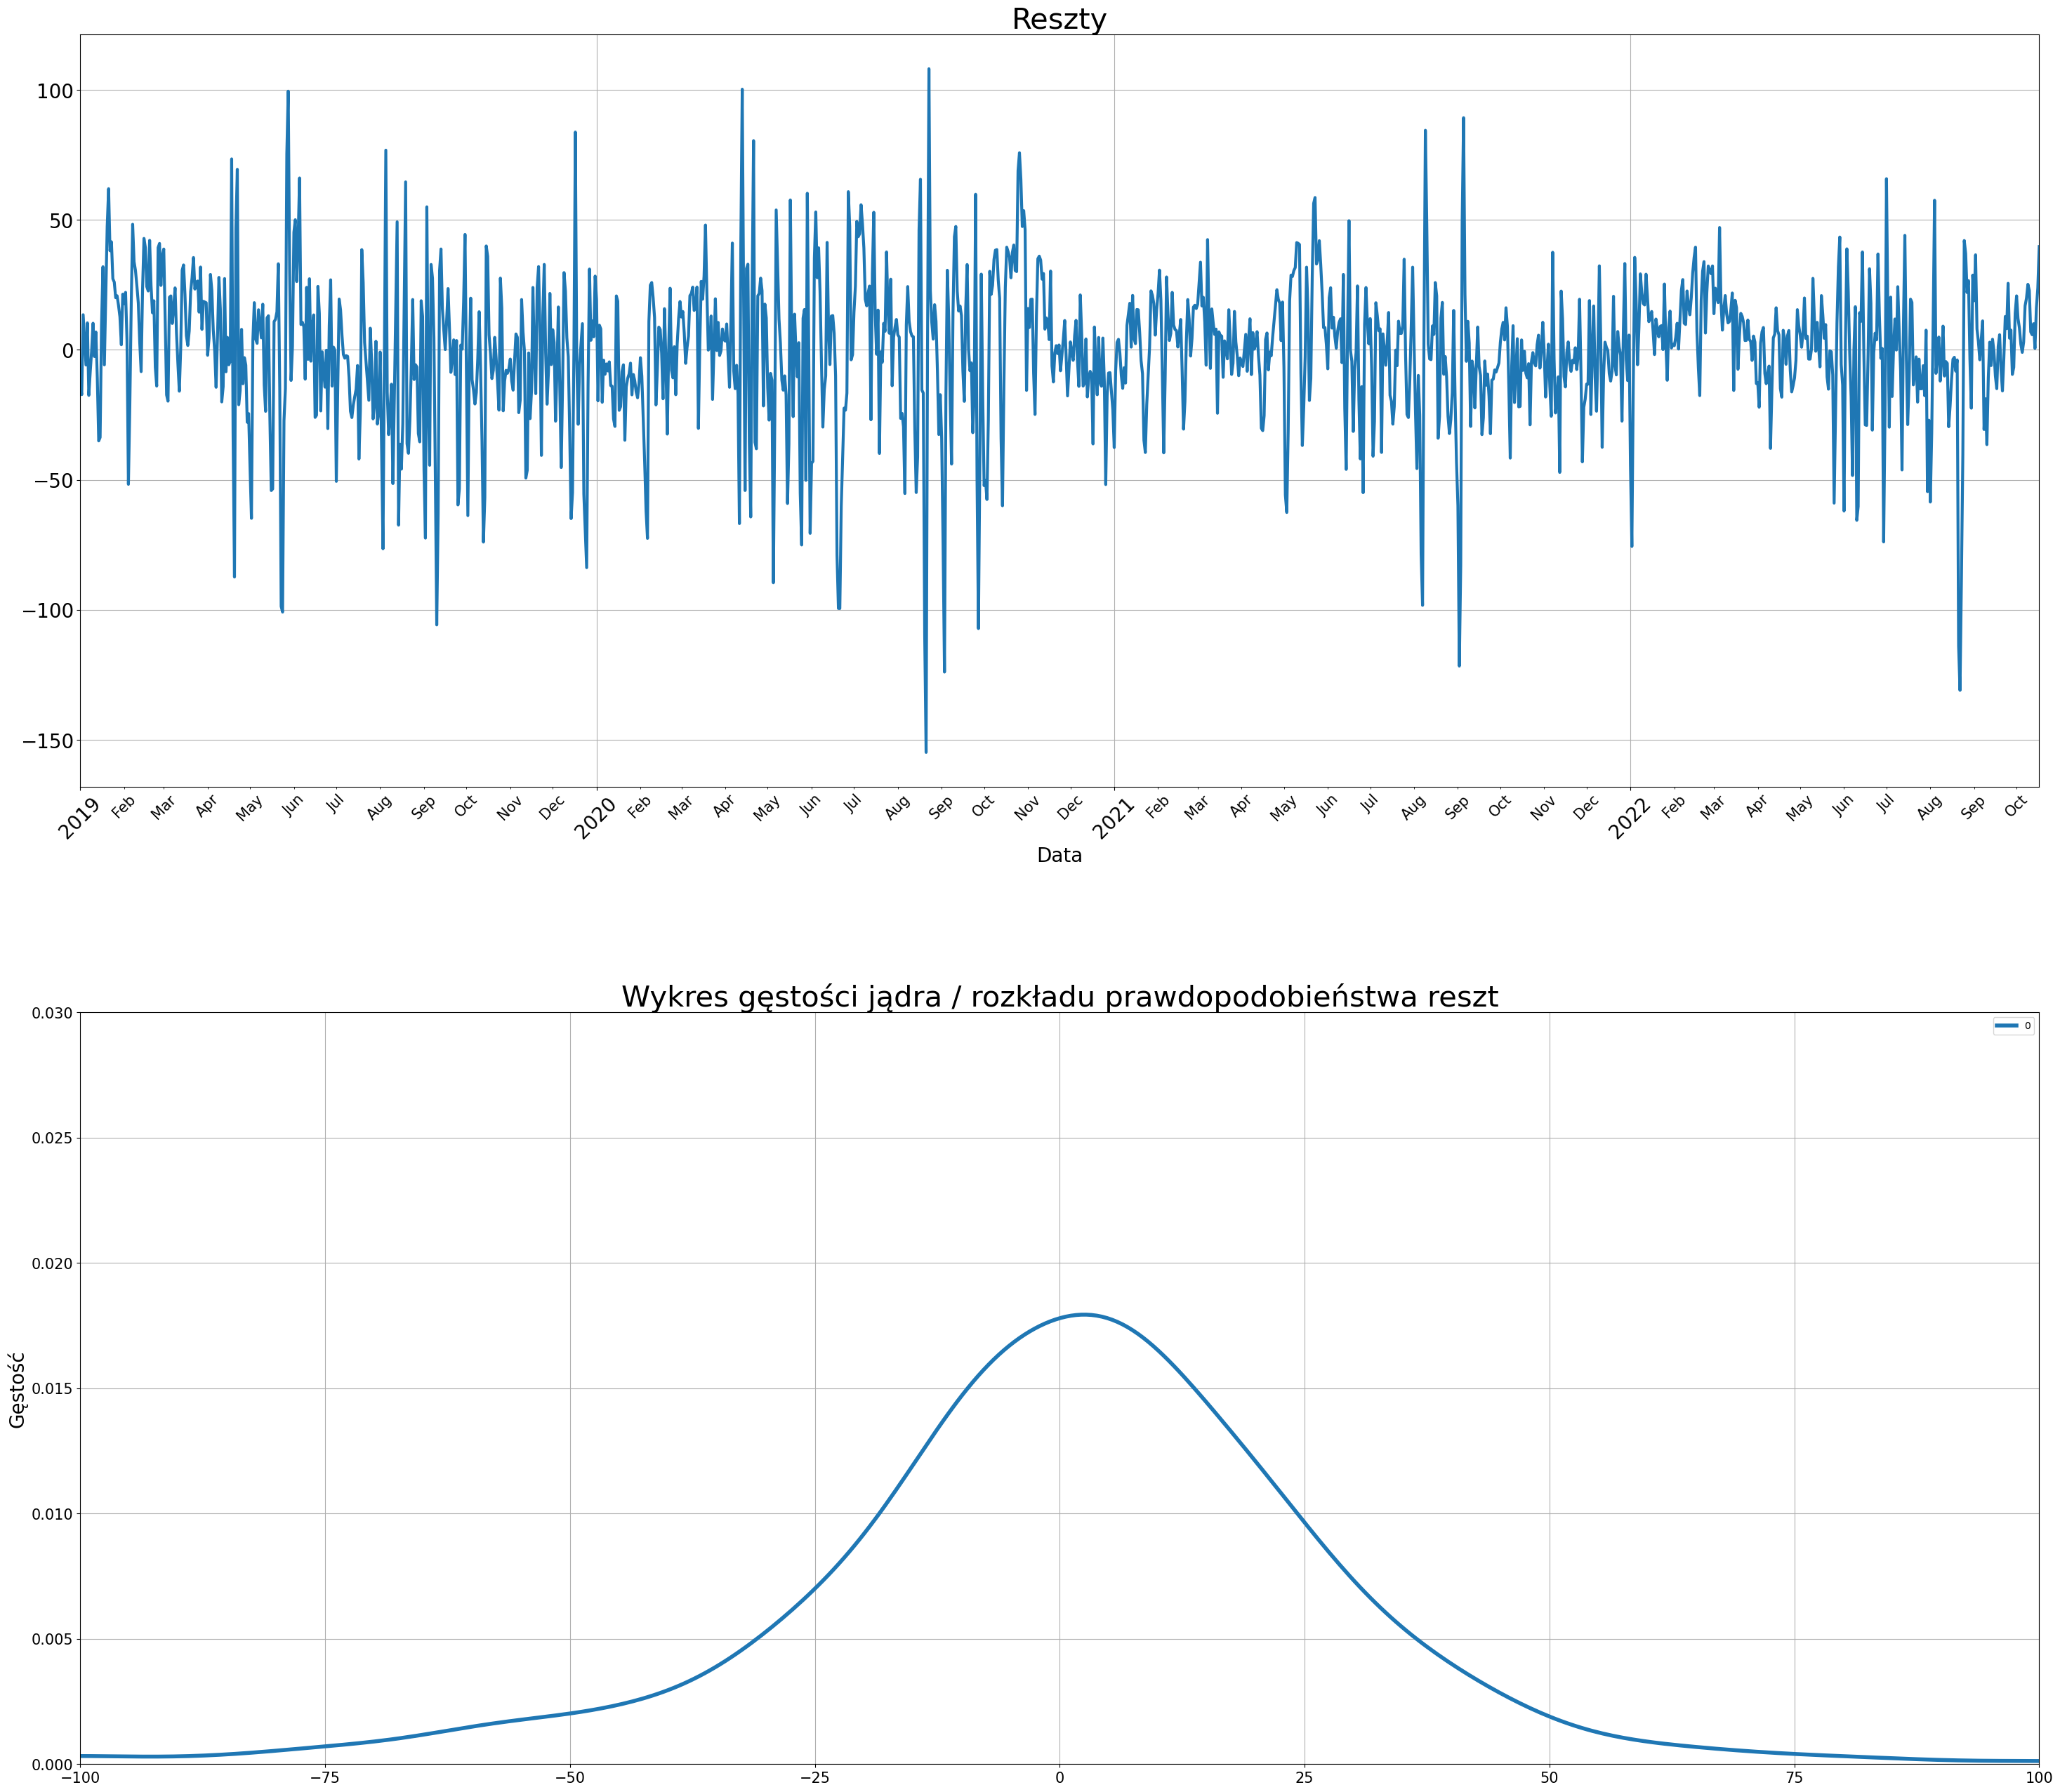

                  0
count  1.377000e+03
mean   6.220990e-14
std    2.804624e+01
min   -1.548907e+02
25%   -1.301016e+01
50%    2.031405e+00
75%    1.616090e+01
max    1.081886e+02


In [5]:
# Dataframe z resztami modelu
residuals = pd.DataFrame(model.resid)

# Okno wykresów
fig, axes = plt.subplots(figsize=(36,32), ncols=1, nrows=2, gridspec_kw={'hspace': 0.3})
months_locator = MonthLocator()
months_fmt = DateFormatter("%b")
years_locator = YearLocator()
years_fmt = DateFormatter("%Y")

# Wykres reszt
axes[0].plot(station_data['Date'][:len(train_data)],residuals.iloc[:,0], linewidth=3)
axes[0].set_xlim(station_data['Date'][:len(train_data)].min(), station_data['Date'][:len(train_data)].max())
axes[0].set_xlabel('Data', fontsize=20)
axes[0].set_title('Reszty', fontsize=30)
axes[0].grid()
axes[0].xaxis.set_minor_locator(months_locator)
axes[0].xaxis.set_minor_formatter(months_fmt)
axes[0].xaxis.set_major_locator(years_locator)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].tick_params(axis='both', which='minor', labelsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=20)
plt.setp(axes[0].xaxis.get_minorticklabels(), rotation=45)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Wykres gęstości jądra reszt / rozkład prawdopodobieństwa reszt
residuals.plot(kind='kde', ax=axes[1], linewidth=4)
axes[1].set_xlim(-100, 100)
axes[1].set_ylim(0, 0.03)
axes[1].set_title('Wykres gęstości jądra / rozkładu prawdopodobieństwa reszt', fontsize=30)
axes[1].set_ylabel('Gęstość', fontsize=20)
axes[1].tick_params(axis='both', labelsize=15)
axes[1].grid()

plt.show()

# Statystyki opisowe reszt
print(residuals.describe())

## Metryki błędu

Wśród metryk błędu znajdują się: błąd średniokwadratowy, pierwiastek z błędu średniokwadratowego, średni błąd względny, maksymalny błąd bezwzględny i względny. O ile mniejszy błąd najpewniej będzie oznaczać lepszy model, to należy zachować ostrożność przy interpretacji — np. dla pomiaru 40 cm i predykcji 50 cm, i dla pomiaru 400 cm i predykcji 500 cm błąd względny będzie taki sam, za to błąd bezwzględny czy kwadratowy będzie wyraźnie się różnić.

In [6]:
# Prawdziwe dane testowe
y_true = test_data['GŁOGÓW']

# Błąd średniokwadratowy
mse = mean_squared_error(y_true=y_true, y_pred=test_prediction, squared=True)

# Pierwiastek z błędu kwadratowego
rmse = mean_squared_error(y_true=y_true, y_pred=test_prediction, squared=False)

# Średni błąd względny
mape = mean_absolute_percentage_error(y_true=y_true, y_pred=test_prediction)

# Maksymalny błąd bezwzględny
max_absolute_error = max_error(y_true=y_true, y_pred=test_prediction)

# Maksymalny błąd względny
max_relative_error = max(abs((test_data['GŁOGÓW'] - test_prediction) / test_data['GŁOGÓW']))

# Bezwzględny błąd treningowy
train_absolute_error = abs(train_data['GŁOGÓW'] - model_prediction)

# Względny błąd treningowy
train_relative_error = abs((train_data['GŁOGÓW'] - model_prediction) / train_data['GŁOGÓW'])

# Bezwzględny błąd testowy
test_absolute_error = abs(test_data['GŁOGÓW'] - test_prediction)

# Względny błąd testowy
test_relative_error = abs((test_data['GŁOGÓW'] - test_prediction) / test_data['GŁOGÓW'])

# Wyświetlenie powyższych metryk wyliczonych dla predykcji względem zbioru testowego
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.4f' % mape)
print('Test max absolute error: %.3f' % max_absolute_error)
print('Test max relative error: %.4f' % max_relative_error)

Test MSE: 710.112
Test RMSE: 26.648
Test MAPE: 0.0811
Test max absolute error: 103.159
Test max relative error: 0.3866


## Wykresy predykcji, błędu bezwzględnego i błędu względnego

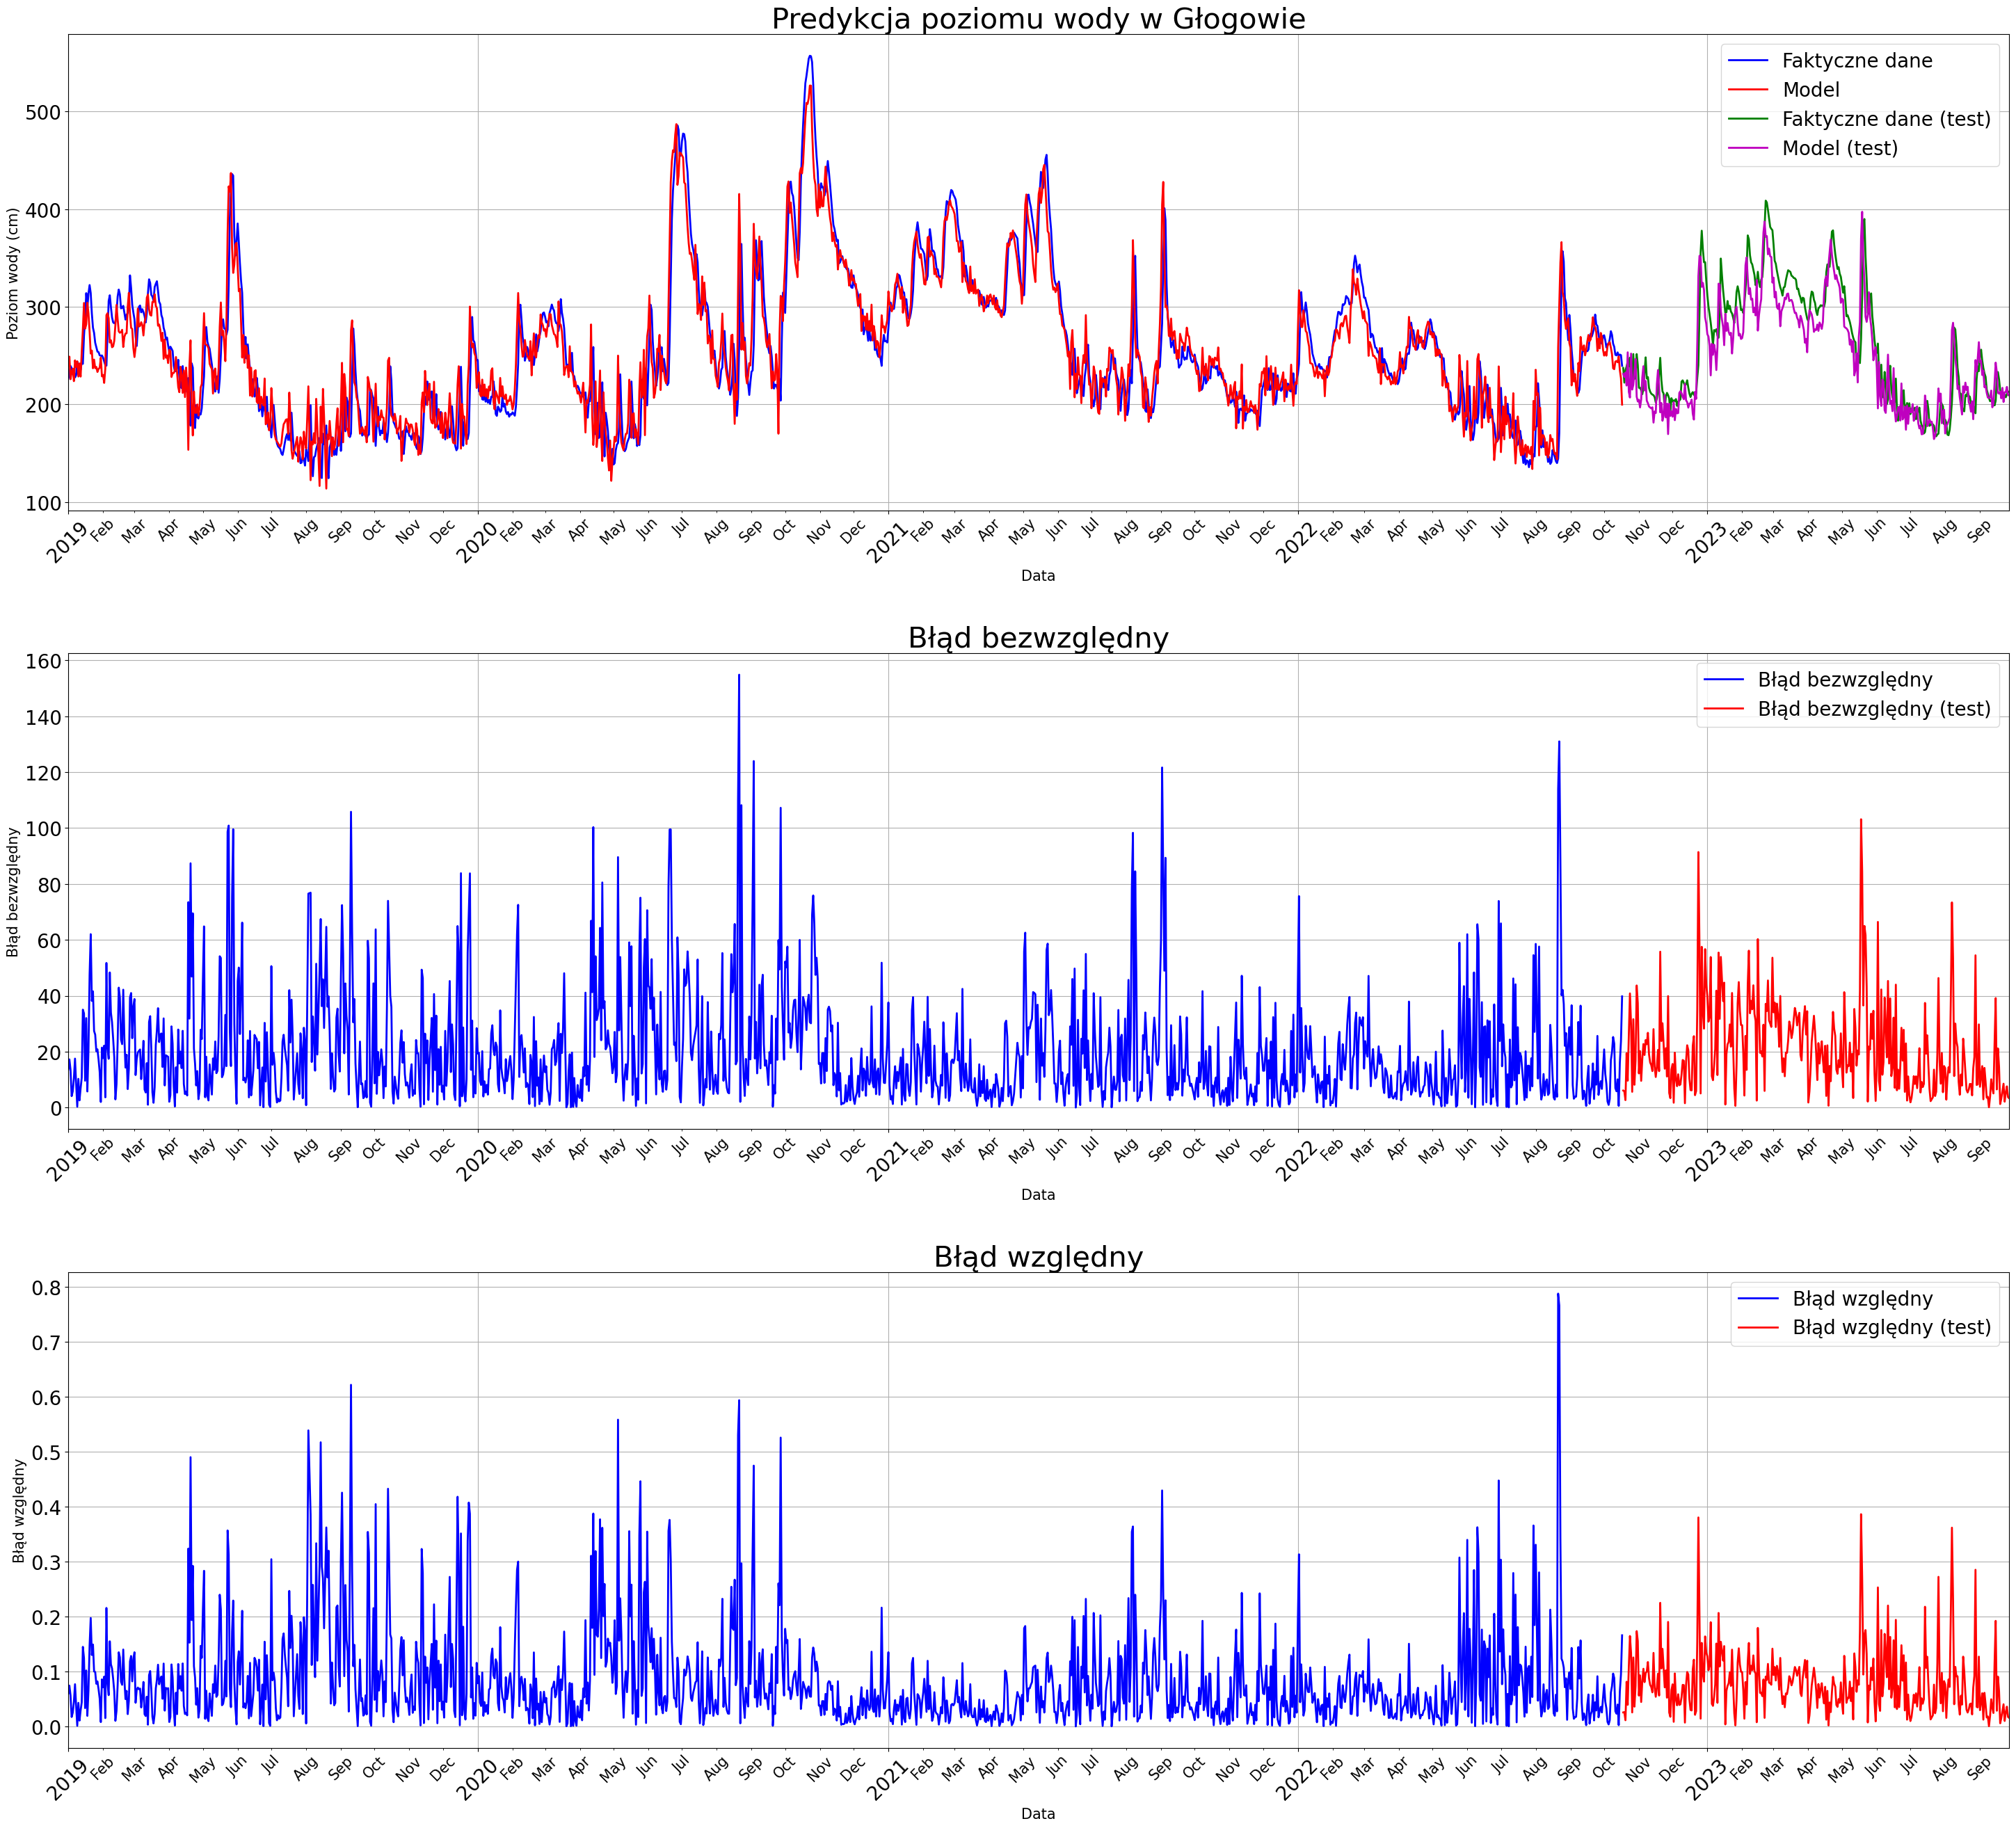

In [7]:
# Funkcja do ustawiania własności wykresu
def set_common_plot_properties(axes_id, title, y_label):
    axes[axes_id].set_xlabel('Data', fontsize=15)
    axes[axes_id].set_ylabel(y_label, fontsize=15)
    axes[axes_id].set_xlim(train_dates.min(), test_dates.max())
    axes[axes_id].set_title(title, fontsize=30)
    axes[axes_id].legend(loc='upper right', fontsize=20)
    axes[axes_id].grid()
    axes[axes_id].xaxis.set_minor_locator(months_locator)
    axes[axes_id].xaxis.set_minor_formatter(months_fmt)
    axes[axes_id].xaxis.set_major_locator(years_locator)
    axes[axes_id].xaxis.set_major_formatter(years_fmt)
    axes[axes_id].tick_params(axis='both', which='minor', labelsize=15)
    axes[axes_id].tick_params(axis='both', which='major', labelsize=20)
    plt.setp(axes[axes_id].xaxis.get_minorticklabels(), rotation=45)
    plt.setp(axes[axes_id].xaxis.get_majorticklabels(), rotation=45)

# Osie X
train_dates = station_data['Date'][:len(train_data)]
test_dates = station_data['Date'][len(train_data):len(train_data) + len(test_data)]

# Okno wykresów
fig, axes = plt.subplots(figsize=(36, 32), nrows=3, ncols=1, gridspec_kw={'hspace': 0.3})
months_locator = MonthLocator()
months_fmt = DateFormatter("%b")
years_locator = YearLocator()
years_fmt = DateFormatter("%Y")

# Wykres predykcji
axes[0].plot(train_dates, train_data['GŁOGÓW'], color='b', label='Faktyczne dane', linewidth=2)
axes[0].plot(train_dates, model_prediction, 'r', label='Model', linewidth=2)
axes[0].plot(test_dates, test_data['GŁOGÓW'], color='g', label='Faktyczne dane (test)', linewidth=2)
axes[0].plot(test_dates, test_prediction, color='m', label='Model (test)', linewidth=2)
set_common_plot_properties(0, 'Predykcja poziomu wody w Głogowie', 'Poziom wody (cm)')

# Wykres błędu bezwzględnego
axes[1].plot(train_dates, train_absolute_error, color='b', label='Błąd bezwzględny', linewidth=2)
axes[1].plot(test_dates, test_absolute_error, color='r', label='Błąd bezwzględny (test)', linewidth=2)
set_common_plot_properties(1, 'Błąd bezwzględny', 'Błąd bezwzględny')

# Wykres błędu względnego
axes[2].plot(train_dates, train_relative_error, color='b', label='Błąd względny', linewidth=2)
axes[2].plot(test_dates, test_relative_error, color='r', label='Błąd względny (test)', linewidth=2)
set_common_plot_properties(2, 'Błąd względny', 'Błąd względny')

# Wyświetlenie wykresów
plt.show()

## Korelacje Pearsona między stacjami

Maksymalna wartość przesunięcia w czasie jednej stacji wobec drugiej, ustawiona na 7 dni (co jest sporym zapasem — ręczna analiza wykazała, że odległość między peakami poziomu wody w stacjach najbardziej oddalonych od Głogowa a stacją w Głogowie rzadko przekraczała 3 dni). Można łatwo zaobserwować trendy w zmienności współczynników wraz ze zmianą przesunięcia w czasie.

In [9]:
# Funkcja do liczenia korelacji Pearsona między dwiema stacjami
def correlation_between_stations(station_1, station_2, lag):
    station_1_id = stations.index(station_1.upper())
    station_2_id = stations.index(station_2.upper())
    correlation = lagged_dfs[lag][station_1_id]['B00020S'].corr(lagged_dfs[0][station_2_id]['B00020S'])
    return round(correlation, 4)

# Stacje
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'BRZEG DOLNY', 'OŁAWA', 'BRZEG', 'RACIBÓRZ-MIEDONIA', 'KRZYŻANOWICE', 'OLZA', 'CHAŁUPKI']

# Grupowanie po dniach i stacjach
data_grouped = data.groupby(['Date', 'Station'])['B00020S'].mean().reset_index()

# Maksymalny lag
max_lag = 7

# Lista od 0 do max_lag
lags = range(max_lag + 1)

# Dwuwymiarowa lista zlagowanych dataframe'ów stacji
# Dostęp do wybranej stacji i lagu: lagged_dfs[lag][id_stacji np. 0 dla Głogowa]
start_date = '2008-01-08'
end_date = '2023-09-30'
lagged_dfs =[[data_grouped[(data_grouped['Date']
                .between(
                    pd.to_datetime(start_date) - pd.DateOffset(days=lag),
                    pd.to_datetime(end_date) - pd.DateOffset(days=lag)
                ))&(data_grouped['Station'] == station)].reset_index(drop=True) for station in stations]for lag in lags
             ]

# Lista stacji, dla których chcemy obliczyć korelację Pearsona względem Głogowa
stations_to_calculate_corr = stations.copy()
stations_to_calculate_corr.remove('GŁOGÓW')

# Wyświetlanie korelacji Pearsona
for station in stations_to_calculate_corr:
    print(f"\nWspółczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: {station.capitalize()} - Głogów")
    for lag in lags:
        print(f"Lag: {lag}, p = {correlation_between_stations(station, 'Głogów', lag)}")


Współczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: Ścinawa - Głogów
Lag: 0, p = 0.9019
Lag: 1, p = 0.9026
Lag: 2, p = 0.8831
Lag: 3, p = 0.8591
Lag: 4, p = 0.8342
Lag: 5, p = 0.8094
Lag: 6, p = 0.7862
Lag: 7, p = 0.7651

Współczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: Malczyce - Głogów
Lag: 0, p = 0.8916
Lag: 1, p = 0.9231
Lag: 2, p = 0.9338
Lag: 3, p = 0.9301
Lag: 4, p = 0.9124
Lag: 5, p = 0.8839
Lag: 6, p = 0.854
Lag: 7, p = 0.8268

Współczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: Brzeg dolny - Głogów
Lag: 0, p = 0.7507
Lag: 1, p = 0.7745
Lag: 2, p = 0.7727
Lag: 3, p = 0.7487
Lag: 4, p = 0.7235
Lag: 5, p = 0.6986
Lag: 6, p = 0.6743
Lag: 7, p = 0.6518

Współczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: Oława - Głogów
Lag: 0, p = 0.8242
Lag: 1, p = 0.8488
Lag: 2, p = 0.8562
Lag: 3, p = 0.8419
Lag: 4, p = 0.817
Lag: 5, p = 0.7899
Lag: 6, p = 0.7634
Lag: 7, p = 0.7387

Współc

### Przesunięcie czasowe stacji (w dniach) względem Głogowa dające najwyższy (prawie najwyższy) współczynnik korelacji:

**Chałupki** - 3 (2) \
**Olza** - 4 (5) - można też spróbować wziąć 3, patrząc na współczynnik bardziej oddalonych od Głogowa Chałupek\
**Krzyżanowice** - 3 (2) \
**Racibórz-Miedonia** - 2 (3) \
**Brzeg** - 2 (1) \
**Oława** - 2 (1) \
**Brzeg Dolny** - 1 (2) \
**Malczyce** - 2 (3) - można też spróbować wziąć 1, patrząc na współczynniki bardziej oddalonych od Głogowa Oławy i Brzegu Dolnego \
**Ścinawa** - 1 (0) 